In [ ]:
%%capture
%matplotlib inline
from functools import partial
import matplotlib.pyplot as plt
import math
try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax
import jax
import jax.numpy as jnp
from jax import jit
from jax.nn.initializers import glorot_normal
try:
    import flax
except ModuleNotFoundError:
    %pip install -qq flax
    import flax
import flax.linen as nn
from flax.training import train_state
import tensorflow_probability.substrates.jax as tfp
from typing import Any, Callable, Sequence
import optax

!pip install jaxopt
import jaxopt
import jax
import jax.numpy as jnp
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
from flax.core import unfreeze
import random

In [ ]:
dist = tfp.distributions
class load(nn.Module):
    features: list

    @nn.compact
    def __call__(self, X):
        for i, feature in enumerate(self.features):
            X = nn.Dense(feature, name=f"layer{i}")(X)
            if i != len(self.features):
                X = nn.relu(X)
        X = nn.Dense(2, name=f'layers_{len(self.features)}')(X)
        X = X.at[1].set(nn.activation.softplus(X[1]))
        return X

    def loss_fn(self, params, X, y):
        print(y.shape)
        def loss(params, X, y):
          mean, var = self.apply(params, X)
          d = dist.Normal(loc=mean, scale=var)
          return -d.log_prob(y)
        return jnp.mean(jax.vmap(loss, in_axes=(None, 0, 0))(params,X, y))

        # y_pred = self.apply(params, X, False, rngs={"dropout": key})
        # mean = y_pred[0]
        # sigma = y_pred[1]
        # loss = (jnp.log(sigma**2) /2+ (((Y - mean)**2)/sigma**2)/2+jnp.log(6.28)/2).sum()
        # return loss

In [ ]:
def fit(model, params, X, y, learning_rate = 0.01, epochs=100, key=0, verbose=False):
    opt = optax.adam(learning_rate=learning_rate)
    opt_state = opt.init(params)

    loss_grad_fn = jax.jit(jax.value_and_grad(model.loss_fn))
    key = jax.random.PRNGKey(key)
    losses = []
    for i in range(epochs):
        key, _ = jax.random.split(key)
        loss_val, grads = loss_grad_fn(params, X, y)
        updates, opt_state = opt.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        losses.append(loss_val)
        if verbose and i % (epochs / 10) == 0:
            print('Loss step {}: '.format(i), loss_val)
    return params, jnp.array(losses)

In [ ]:
def data(points=20,xrange=(-3,3),std = 0.3):
  xx = jnp.linspace(-1,1,1000).reshape(-1,1)
  y_true = jnp.array([[x*10*x] for x in xx])
  yy = jnp.array([[x*10*x + x*x*np.random.normal(0,std)] for x in xx])
  return xx.reshape(1000,1), yy.reshape(1000,1), y_true.reshape(1000,1)

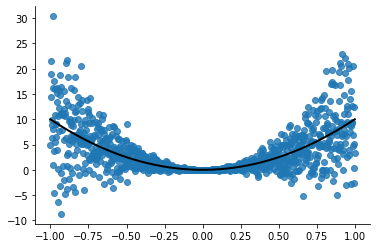

In [ ]:
key, subkey = jax.random.split(jax.random.PRNGKey(0))
X,Y,y_true = data(points=1000, xrange=(-1, 1), std=8) 
plt.figure() 
plt.scatter(X, Y,alpha=0.8)
plt.plot(X ,y_true, linewidth=2,color='black',linestyle='-')
sns.despine()

In [ ]:

model = load([32 , 64, 32])



In [ ]:
n_estimators = 10
x_grid = jnp.linspace(-2,2,1000).reshape(-1,1)
keys = jax.random.split(jax.random.PRNGKey(0),n_estimators)
Y_final = []
parameters=[]
for i in range(n_estimators):
  ids = jax.random.choice(keys[i], jnp.array(range(1000)), (1000,1))
  x, y = X[ids].reshape(-1,1), Y[ids].reshape(-1,1)
  loss = []
  params = model.init(keys[i], x)
  params,losses = fit(model, params, x, y,  epochs=500)
  Y_pred = model.apply(params, x_grid)
  parameters.append(params)
  Y_final.append(Y_pred)

(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)
(1000, 1)


In [ ]:
Y_final = jnp.array(Y_final)
Y_final.shape

(10, 1000, 2)

In [ ]:
means_ = Y_final[:,:,0]
sigmas_ = Y_final[:,:,1]
mean = means_.mean(axis=0)
sigma = (sigmas_ + means_**2).mean(axis=0) - mean**2
mean.shape, sigma.shape

((1000,), (1000,))

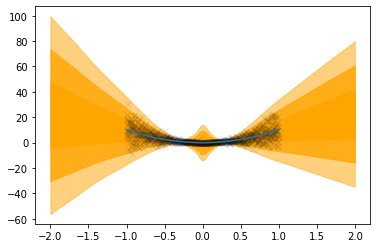

In [ ]:
plt.plot(X,Y,'kx',alpha=0.1)
plt.fill_between(x_grid.squeeze(),mean+sigma,mean-sigma,color='orange',alpha=1)
plt.fill_between(x_grid.squeeze(),mean+2*sigma,mean-2*sigma,color='orange',alpha=0.8)
plt.fill_between(x_grid.squeeze(),mean+3*sigma,mean-3*sigma,color='orange',alpha=0.5)
plt.plot(X,10*X*X)


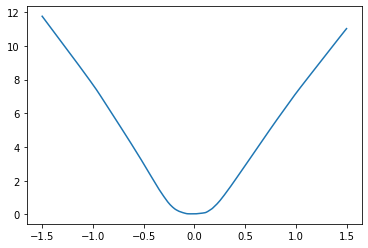

In [ ]:
plt.plot(x_grid,mean)

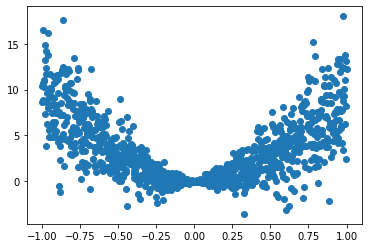

In [ ]:
plt.scatter(X,Y)